<a href="https://colab.research.google.com/github/fmezacr/machinelearning/blob/main/Limites_de_Desicion_en_SUP_NOSUP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comparación de Límites de Desición en Técnicas de Machine Learning: Supervisado y No Supervisado**
### Autor: ***Felipe Meza-Obando***

Esta notebook abarca una comparativa exhaustiva entre diversos algoritmos de aprendizaje supervisado y no supervisado, demostrando sus aplicaciones, diferencias y ventajas en el tratamiento de datos sintéticos y etiquetados. Se pretende proporcionar una guía clara sobre cómo cada técnica puede ser utilizada para extraer conocimiento de los datos, ofreciendo una plataforma para discutir la eficacia y eficiencia de cada método en escenarios prácticos de modelado.


## Clasificación con Modelos de Aprendizaje Supervisado

Esta sección de la notebook se dedica a la implementación y evaluación de varios modelos de clasificación utilizando un conjunto de datos etiquetado. El propósito es aplicar diferentes algoritmos para predecir la clase de cada muestra basándose en sus características y comparar su rendimiento.

### Modelos Implementados:
- **Regresión Logística**: Un modelo lineal para clasificación binaria o multinomial.
- **Árboles de Decisión**: Modela decisiones y sus posibles consecuencias como un árbol.
- **Random Forest**: Un ensamble de árboles de decisión, mejora la precisión mediante el promedio de múltiples árboles.
- **Support Vector Machines (SVM)**: Crea un hiperplano o conjunto de hiperplanos en un espacio de alta dimensión para la clasificación.
- **Redes Neuronales Artificiales**: Utiliza redes neuronales para capturar relaciones complejas entre las entradas y las etiquetas.

Cada modelo es evaluado en términos de precisión y tiempo de ejecución, permitiendo no solo identificar el más preciso sino también el más eficiente en términos computacionales. Esta comparativa nos ofrece insights valiosos sobre la idoneidad de cada método para aplicaciones en tiempo real y escenarios específicos.




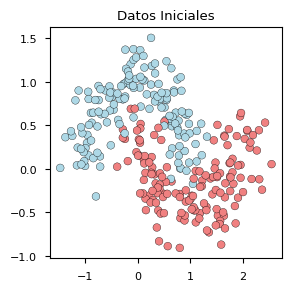

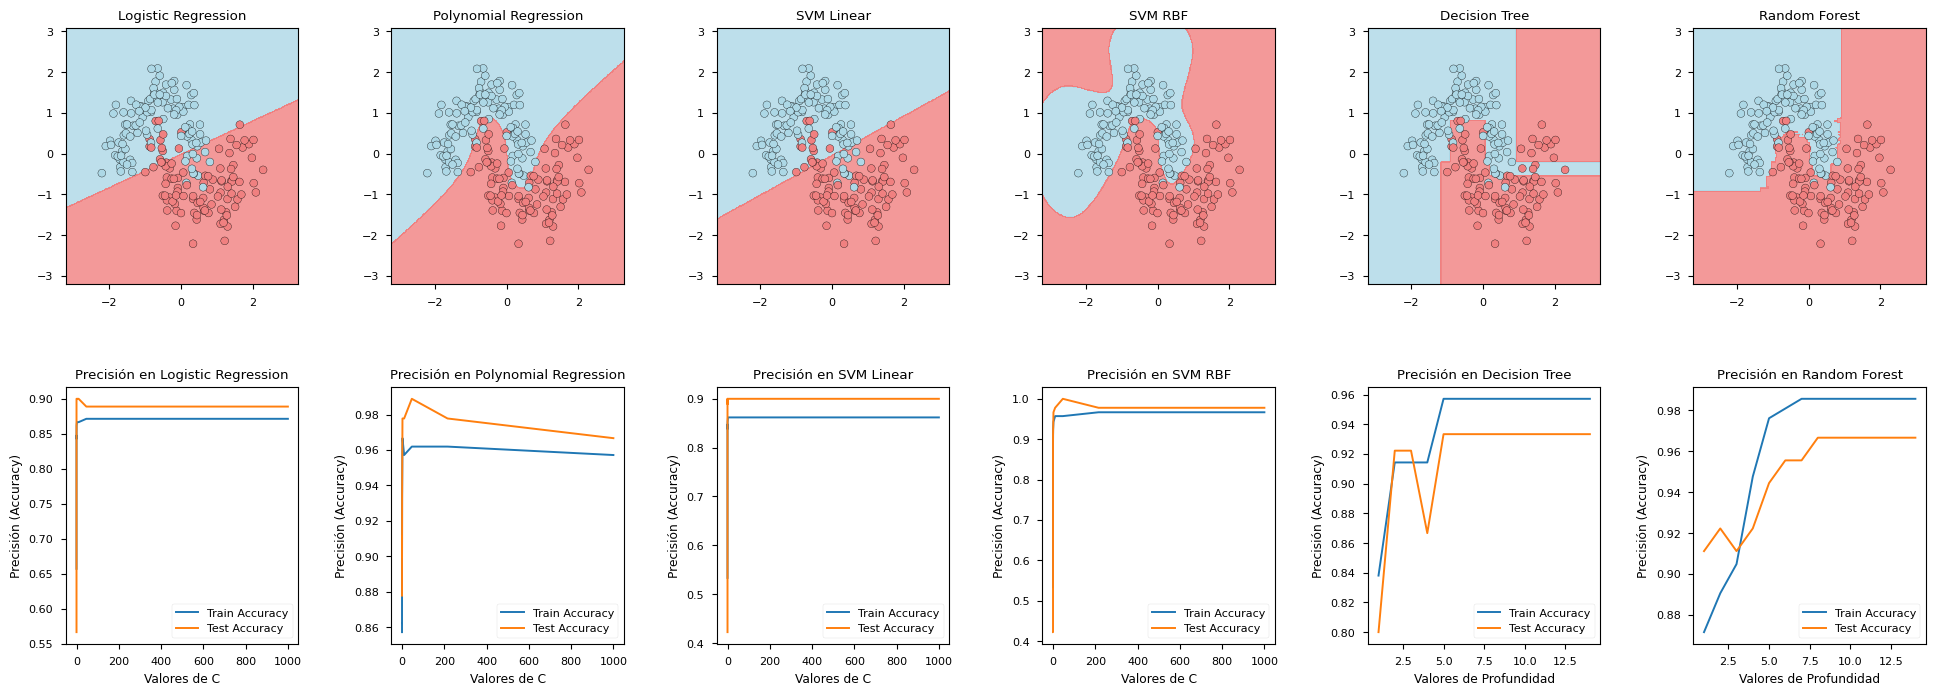

Logistic Regression: 0.18 segundos
Polynomial Regression: 0.24 segundos
SVM Linear: 0.26 segundos
SVM RBF: 0.05 segundos
Decision Tree: 0.03 segundos
Random Forest: 2.20 segundos


In [63]:
# Importación de librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import time

plt.style.use("seaborn-v0_8-paper")

# Generar un conjunto de datos sintético con forma de dos lunas
X, y = make_moons(n_samples=300, noise=0.2, random_state=42)

# Escalar las características para tener media 0 y varianza 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Colores para las clases en las visualizaciones, usando tonos más suaves
cmap_light = ListedColormap(['#add8e6', '#f08080'])  # lightblue y lightcoral

# Visualización inicial de los datos con colores consistentes
fig_initial, ax_initial = plt.subplots(figsize=(3, 3))  # Tamaño similar al de las subfiguras
scatter = ax_initial.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_light, edgecolors='k')
ax_initial.set_title('Datos Iniciales')
plt.show()

# Preparación de la figura para la visualización
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(24, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Definición de los modelos a comparar, configurando parámetros como máximo de iteraciones y tolerancia
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, tol=1e-4, random_state=42),
    'Polynomial Regression': make_pipeline(PolynomialFeatures(degree=3), LogisticRegression(max_iter=1000, tol=1e-4)),
    'SVM Linear': SVC(kernel='linear', max_iter=150000, random_state=42),
    'SVM RBF': SVC(kernel='rbf', max_iter=10000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42),  # Profundidad configurada
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42)  # Número de árboles configurado
}

# Rango de hiperparámetros a evaluar para cada modelo
param_range = {
    'Logistic Regression': np.logspace(-3, 3, 10),
    'Polynomial Regression': np.logspace(-3, 3, 10),
    'SVM Linear': np.logspace(-3, 3, 10),
    'SVM RBF': np.logspace(-3, 3, 10),
    'Decision Tree': np.arange(1, 15, 1),
    'Random Forest': np.arange(1, 15, 1)
}

# Diccionario para almacenar los tiempos de entrenamiento de cada modelo
training_times = {}

# Función para dibujar los límites de decisión de cada modelo
def plot_decision_boundary(model, ax, title):
    h = .02
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=cmap_light)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_light, edgecolors='k')
    ax.set_title(title)

# Bucle para entrenar y evaluar cada modelo, y medir el tiempo de entrenamiento
for idx, (name, model) in enumerate(models.items()):
    train_scores = []
    test_scores = []
    start_time = time.time()  # Comienza a medir el tiempo
    for param in param_range[name]:
        if 'Polynomial' in name:
            model.set_params(polynomialfeatures__degree=3, logisticregression__C=param)
        elif 'Logistic' in name:
            model.set_params(C=param)
        elif 'SVM' in name:
            model.set_params(C=param)
        elif 'Tree' in name or 'Forest' in name:
            model.set_params(max_depth=param)

        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        train_scores.append(accuracy_score(y_train, train_pred))
        test_scores.append(accuracy_score(y_test, test_pred))

    end_time = time.time()  # Finaliza la medición de tiempo
    training_times[name] = end_time - start_time  # Almacenar el tiempo transcurrido

    plot_decision_boundary(model, axes[0, idx], name)
    axes[1, idx].plot(param_range[name], train_scores, label='Train Accuracy')
    axes[1, idx].plot(param_range[name], test_scores, label='Test Accuracy')
    axes[1, idx].set_xlabel(f'Valores de {"C" if "SVM" in name or "Logistic" in name else "Profundidad" if "Tree" in name or "Forest" in name else "C"}')
    axes[1, idx].set_ylabel('Precisión (Accuracy)')
    axes[1, idx].set_title(f'Precisión en {name}')
    axes[1, idx].legend()


plt.show("seaborn-v0_8-notebook")  # Mostrar las figuras


# Imprimir los tiempos de entrenamiento para cada modelo
for name, time_taken in training_times.items():
    print(f"{name}: {time_taken:.2f} segundos")


## Clustering con Algoritmos de Aprendizaje No Supervisado

En esta sección de la notebook, exploramos diferentes algoritmos de clustering aplicados a un conjunto de datos sintético generado mediante la función `make_blobs` de Scikit-learn. El objetivo es demostrar cómo diversos algoritmos agrupan datos sin etiquetas previas en grupos basados en similitudes entre los puntos de datos.

### Algoritmos Utilizados:
- **K-Means**: Identifica k grupos centrados en los centroides.
- **DBSCAN**: Basado en densidad, agrupa puntos que están cercanos y marca como ruido los puntos que están en regiones de baja densidad.
- **Agglomerative Clustering**: Un enfoque jerárquico que fusiona iterativamente los pares de clusters más cercanos.
- **Spectral Clustering**: Utiliza los eigenvalores de la matriz de similitud de los datos para reducir dimensiones y luego emplea un método como K-Means en el espacio de dimensiones reducidas.
- **Mean Shift**: Busca centroides de clústeres desplazándose hacia regiones de mayor densidad de datos.

Cada uno de estos métodos ofrece una perspectiva única sobre cómo los datos pueden ser agrupados, y la visualización de estos grupos nos ayuda a entender las características del conjunto de datos y la eficacia de cada técnica de clustering.


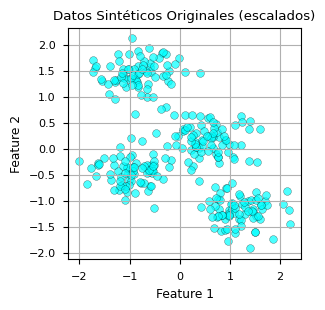

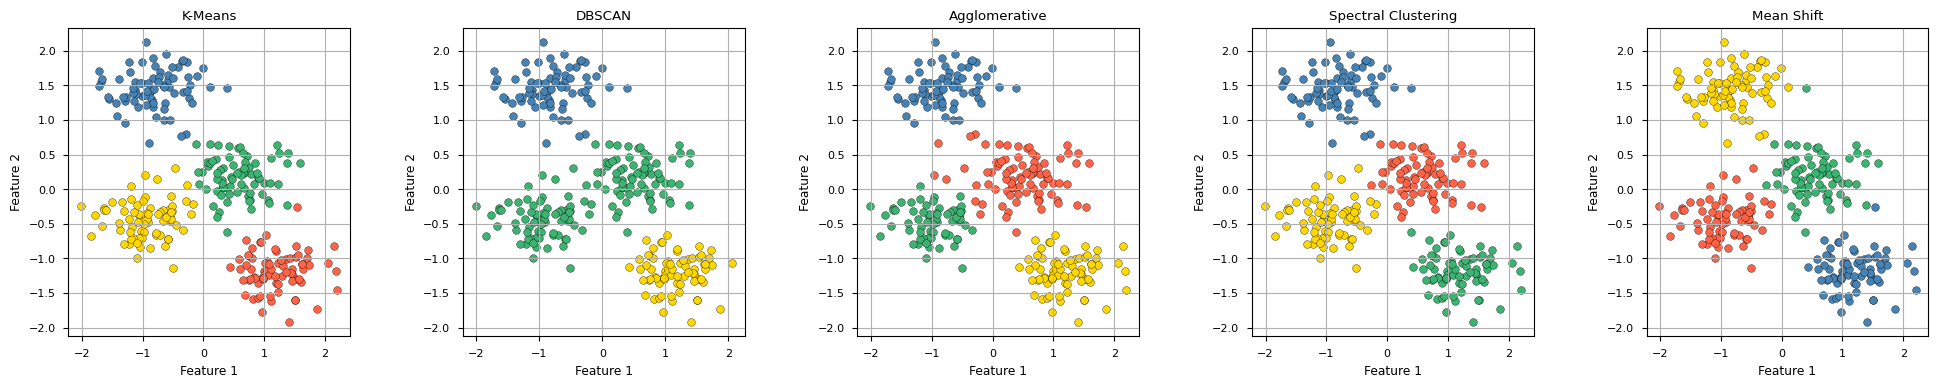

Tiempo de ejecución - K-Means: 0.0111 segundos
Tiempo de ejecución - DBSCAN: 0.0031 segundos
Tiempo de ejecución - Agglomerative: 0.0027 segundos
Tiempo de ejecución - Spectral Clustering: 0.0285 segundos
Tiempo de ejecución - Mean Shift: 3.0407 segundos


In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, MeanShift
from matplotlib.colors import ListedColormap
import time

# Crear un conjunto de datos sintético con make_blobs
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.70, random_state=0)

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Crear la figura inicial con los datos originales (todos en un solo color)
plt.figure(figsize=(3, 3))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], color='cyan', edgecolor='k', alpha=0.7)
plt.title('Datos Sintéticos Originales (escalados)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

# Colores para los grupos
cmap = ListedColormap(['#FF6347', '#4682B4', '#3CB371', '#FFD700'])

# Lista de modelos de clustering a aplicar
clustering_algorithms = {
    'K-Means': KMeans(n_clusters=4, n_init=10, random_state=42),
    'DBSCAN': DBSCAN(eps=0.4, min_samples=8),
    'Agglomerative': AgglomerativeClustering(n_clusters=4),
    'Spectral Clustering': SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42),
    'Mean Shift': MeanShift(bandwidth=0.5)
}

# Crear la figura para los gráficos de clustering
fig, axes = plt.subplots(1, len(clustering_algorithms), figsize=(24, 4))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Diccionario para almacenar tiempos de ejecución
times = {}

# Aplicar cada algoritmo de clustering y graficar los resultados
for ax, (name, algorithm) in zip(axes, clustering_algorithms.items()):
    start_time = time.time()
    labels = algorithm.fit_predict(X_scaled)
    times[name] = time.time() - start_time

    # Graficar los resultados sin fondo de color
    unique_labels = np.unique(labels)
    unique_colors = cmap(np.linspace(0, 1, len(unique_labels)))
    for label, color in zip(unique_labels, unique_colors):
        if label != -1:  # DBSCAN puede tener puntos de ruido marcados como -1
            ax.scatter(X_scaled[labels == label, 0], X_scaled[labels == label, 1], c=[color], label=f'Cluster {label}', edgecolor='k')

    ax.set_title(f"{name}")
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.grid(True)

plt.show()

# Imprimir los tiempos de ejecución para cada algoritmo
for name, time_taken in times.items():
    print(f"Tiempo de ejecución - {name}: {time_taken:.4f} segundos")

